In [8]:
# env - enexis-may-01-env-run
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import polars as pl
import os
from datetime import datetime
import time
import sqlite3
from pathlib import Path
import logging
import json
import joblib
import itertools

from pathlib import Path
PROJECT_ROOT = Path.cwd()

LOG_FILE_NAME = "/Users/sgawde/work/eaisi-code/main-branch-21may/ENEXIS/src/models/logs/warp-prophet-model-json.log"

logging.basicConfig(
    level=logging.INFO,
    #filename=str(PROJECT_ROOT / "logs" / "warp-prophet-model-json.log"),
    filename=LOG_FILE_NAME,
    filemode='a',
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('warp-prophet-model')


#CONFIG_PATH = PROJECT_ROOT / "src" / "config" / "config.json"
CONFIG_PATH = "/Users/sgawde/work/eaisi-code/main-branch-21may/ENEXIS/src/config/config.json"

with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

# Custom function for MAPE and sMAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

def compute_aic(y_true, y_pred, num_params):
    residuals = y_true - y_pred
    mse = np.mean(residuals**2)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * num_params
    return aic

results = []

# WARP_DATA_FILE_PATH = PROJECT_ROOT / "src" / "data" / "warp-csv-dataset.csv"
WARP_DATA_FILE_PATH = "/Users/sgawde/work/eaisi-code/main-branch-21may/ENEXIS/src/data/warp-csv-dataset.csv"
logger.info(f"WARP_DATA_FILE_PATH: {WARP_DATA_FILE_PATH}")


try:
    with open(WARP_DATA_FILE_PATH, 'rb') as csv_file:
        df_pd_orig = pd.read_csv(csv_file)
    logger.info(f"Loaded data from {WARP_DATA_FILE_PATH}")
except Exception as e:
    logger.error(f"Failed to load data: {e}")
    raise

df = df_pd_orig.copy()

print(df.head())


   Price            target_datetime  Load  shortwave_radiation  \
0    0.0  2025-05-31 23:00:00+00:00   0.0                  0.0   
1    0.0  2025-05-31 22:00:00+00:00   0.0                  0.0   
2    0.0  2025-05-31 21:00:00+00:00   0.0                  0.0   
3    0.0  2025-05-31 20:00:00+00:00   0.0                  0.0   
4    0.0  2025-05-31 19:00:00+00:00   0.0                  0.0   

   temperature_2m  direct_normal_irradiance  diffuse_radiation  Flow_NO  \
0             0.0                       0.0                0.0      0.0   
1             0.0                       0.0                0.0      0.0   
2             0.0                       0.0                0.0      0.0   
3             0.0                       0.0                0.0      0.0   
4             0.0                       0.0                0.0      0.0   

   yearday_cos  Flow_GB  month  is_dst  yearday_sin  is_non_working_day  \
0    -0.855631      0.0      5       1     0.517586                   1   
1 

In [14]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pad naar de SQLite-database
db_path = '/Users/sgawde/work/eaisi-code/main-branch-21may/ENEXIS/src/data/WARP.db'

# Maak verbinding met de database
conn = sqlite3.connect(db_path)

# Lees de 'master_warp'-tabel in een Pandas DataFrame
query = "SELECT * FROM master_warp"
df = pd.read_sql_query(query, conn)

# Sluit de verbinding
conn.close()

# Controleer kolommen
print(df.columns)

Index(['Price', 'target_datetime', 'Load', 'shortwave_radiation',
       'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation',
       'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin',
       'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover',
       'weekday_sin', 'hour_sin', 'weekday_cos'],
      dtype='object')


In [9]:
print(df.columns)

Index(['Price', 'target_datetime', 'Load', 'shortwave_radiation',
       'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation',
       'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin',
       'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover',
       'weekday_sin', 'hour_sin', 'weekday_cos'],
      dtype='object')


In [13]:
# Stel een jaartal in (bijvoorbeeld 2025)
year = 2025

# Maak een nieuwe Timestamp kolom aan
df['target_datetime'] = pd.to_datetime({
    'year': year,
    'month': df['month'],
    'day': 1  # tijdelijke placeholder, wordt hieronder aangepast
}) + pd.to_timedelta(df['day_of_year'] - 1, unit='D') + pd.to_timedelta(df['hour'], unit='h')

print(df.head())

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/miniconda3/envs/enexis-may-01-env-run/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'day_of_year'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/miniconda3/envs/enexis-may-01-env-run/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_21005/2548837197.py", line 9

In [47]:
from sklearn.ensemble import RandomForestRegressor

# Feature engineering
df = df.dropna()

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01')
train_end = pd.Timestamp('2025-01-07 23:59:59')
test_start = pd.Timestamp('2025-01-08')
test_end = pd.Timestamp('2025-01-14 23:59:59')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

X_train = train[['hour', 'day_of_week']]
y_train = train['Price']
X_test = test[['hour', 'day_of_week']]
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.04026397797619049
MAE: 0.04026397797619049
RMSE: 0.051996265419694314


In [48]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pad naar de SQLite-database
db_path = 'C:/Users/shba/Documents/JADS project/ENEXIS/src/data/WARP2.db'

# Maak verbinding met de database
conn = sqlite3.connect(db_path)

# Lees de 'master_warp'-tabel in een Pandas DataFrame
query = "SELECT * FROM master_warp"
df = pd.read_sql_query(query, conn)

# Sluit de verbinding
conn.close()

# Controleer kolommen
print(df.columns)

# Stel een jaartal in (bijvoorbeeld 2025)
year = 2025

# Maak een nieuwe Timestamp kolom aan
df['Timestamp'] = pd.to_datetime({
    'year': year,
    'month': df['month'],
    'day': 1  # tijdelijke placeholder, wordt hieronder aangepast
}) + pd.to_timedelta(df['day_of_year'] - 1, unit='D') + pd.to_timedelta(df['hour'], unit='h')

# Feature engineering
df = df.dropna()

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01')
train_end = pd.Timestamp('2025-01-07 23:59:59')
test_start = pd.Timestamp('2025-01-08')
test_end = pd.Timestamp('2025-01-14 23:59:59')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

# Features voor het model
features = [
    'hour', 'day_of_week',
    'yearday_sin', 'yearday_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos'
]

X_train = train[features]
y_train = train['Price']
X_test = test[features]
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

Index(['hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'yearday_sin', 'yearday_cos',
       'local_datetime', 'is_dst', 'is_holiday', 'is_weekend',
       'is_non_working_day', 'target_datetime', 'Load', 'Price', 'Flow_BE',
       'Flow_DE', 'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow',
       'temperature_2m', 'wind_speed_10m', 'apparent_temperature',
       'cloud_cover', 'snowfall', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'Wind_Vol',
       'WindOffshore_Vol', 'Solar_Vol', 'Nuclear_Vol'],
      dtype='object')
MAE: 0.034083836309523816
RMSE: 0.04151675941232951


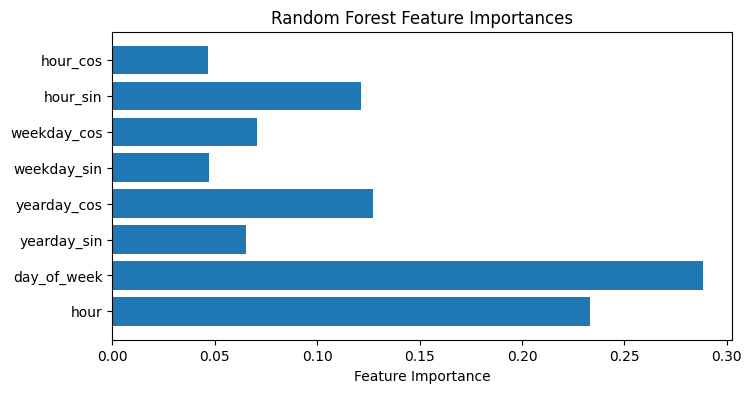

In [49]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

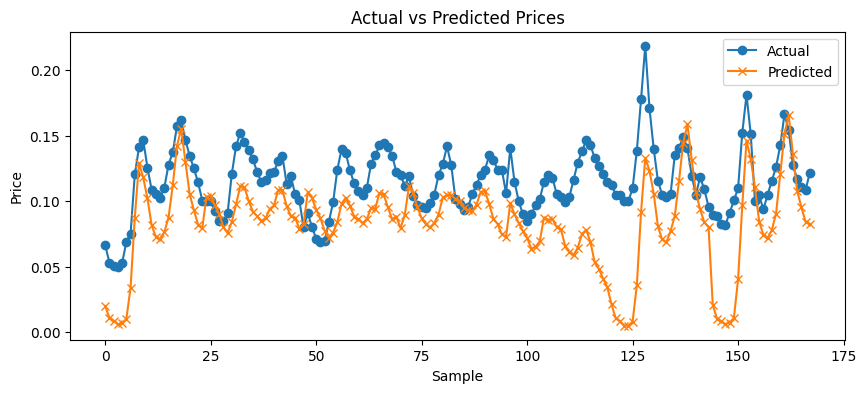

In [50]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.show()

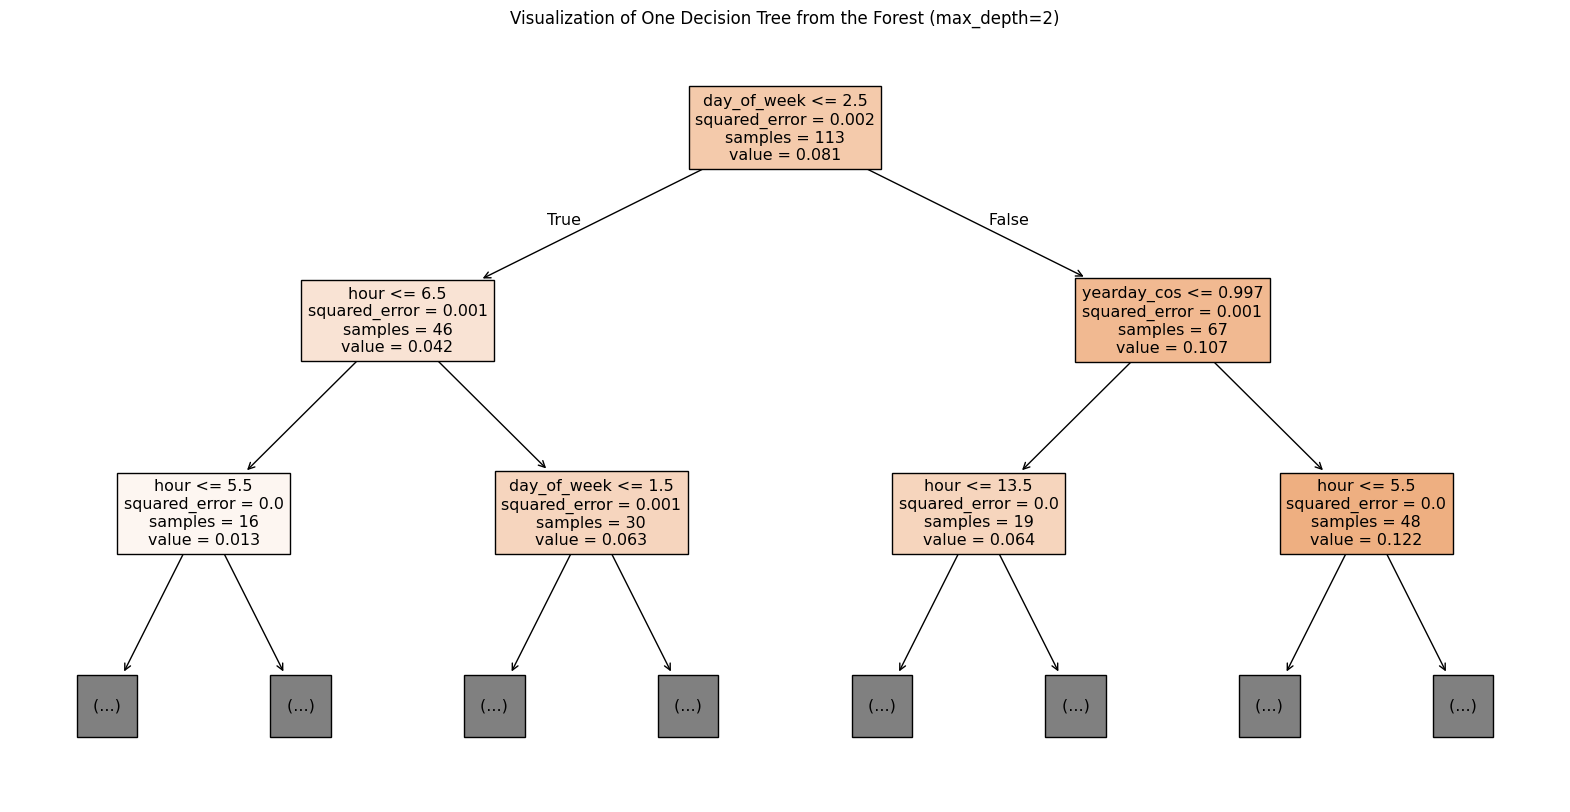

In [51]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=feature_names, filled=True, max_depth=2)
plt.title("Visualization of One Decision Tree from the Forest (max_depth=2)")
plt.show()

In [52]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pad naar de SQLite-database
db_path = 'C:/Users/shba/Documents/JADS project/ENEXIS/src/data/WARP2.db'

# Maak verbinding met de database
conn = sqlite3.connect(db_path)

# Lees de 'master_warp'-tabel in een Pandas DataFrame
query = "SELECT * FROM master_warp"
df = pd.read_sql_query(query, conn)

# Sluit de verbinding
conn.close()

# Controleer kolommen
print(df.columns)

# Stel een jaartal in (bijvoorbeeld 2025)
year = 2025

# Maak een nieuwe Timestamp kolom aan
df['Timestamp'] = pd.to_datetime({
    'year': year,
    'month': df['month'],
    'day': 1  # tijdelijke placeholder, wordt hieronder aangepast
}) + pd.to_timedelta(df['day_of_year'] - 1, unit='D') + pd.to_timedelta(df['hour'], unit='h')

# Feature engineering
df = df.dropna()

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01')
train_end = pd.Timestamp('2025-01-07 23:59:59')
test_start = pd.Timestamp('2025-01-08')
test_end = pd.Timestamp('2025-01-14 23:59:59')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

# Features voor het model
features = [
    'hour', 'day_of_week',
    'yearday_sin', 'yearday_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 
    'hour_cos', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 
    'diffuse_radiation', 'Flow_NO', 'Flow_GB', 'month', 'is_dst', 'wind_speed_10m',
    'is_non_working_day', 'is_weekend', 'cloud_cover'
]

X_train = train[features]
y_train = train['Price']
X_test = test[features]
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

Index(['hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'yearday_sin', 'yearday_cos',
       'local_datetime', 'is_dst', 'is_holiday', 'is_weekend',
       'is_non_working_day', 'target_datetime', 'Load', 'Price', 'Flow_BE',
       'Flow_DE', 'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow',
       'temperature_2m', 'wind_speed_10m', 'apparent_temperature',
       'cloud_cover', 'snowfall', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'Wind_Vol',
       'WindOffshore_Vol', 'Solar_Vol', 'Nuclear_Vol'],
      dtype='object')
MAE: 0.02054762261904764
RMSE: 0.025594940791266813


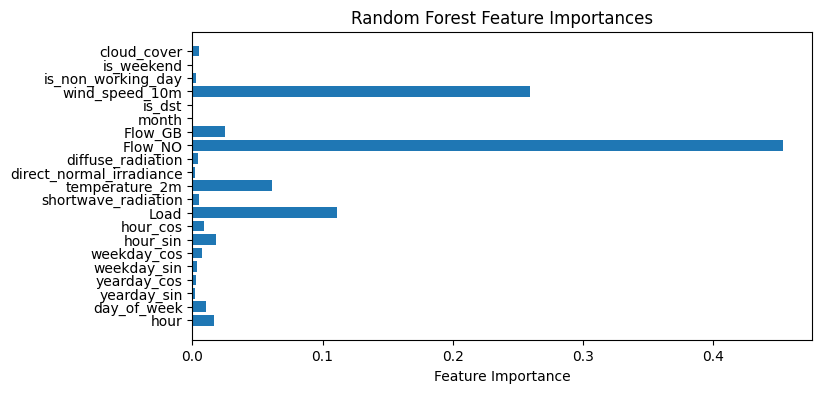

In [53]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

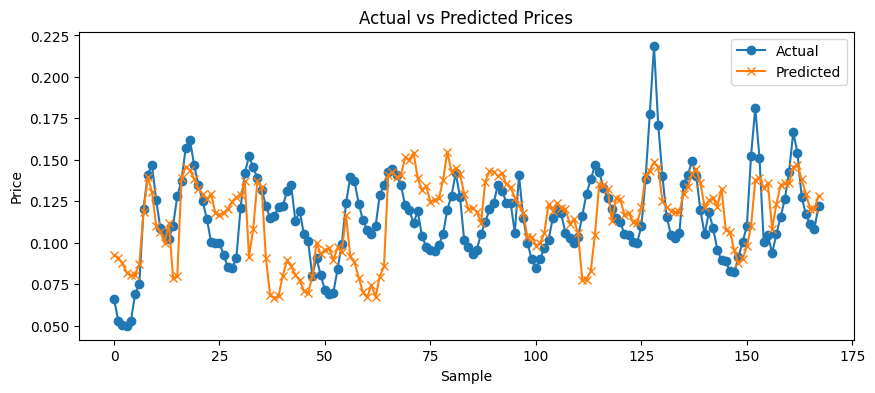

In [54]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.show()

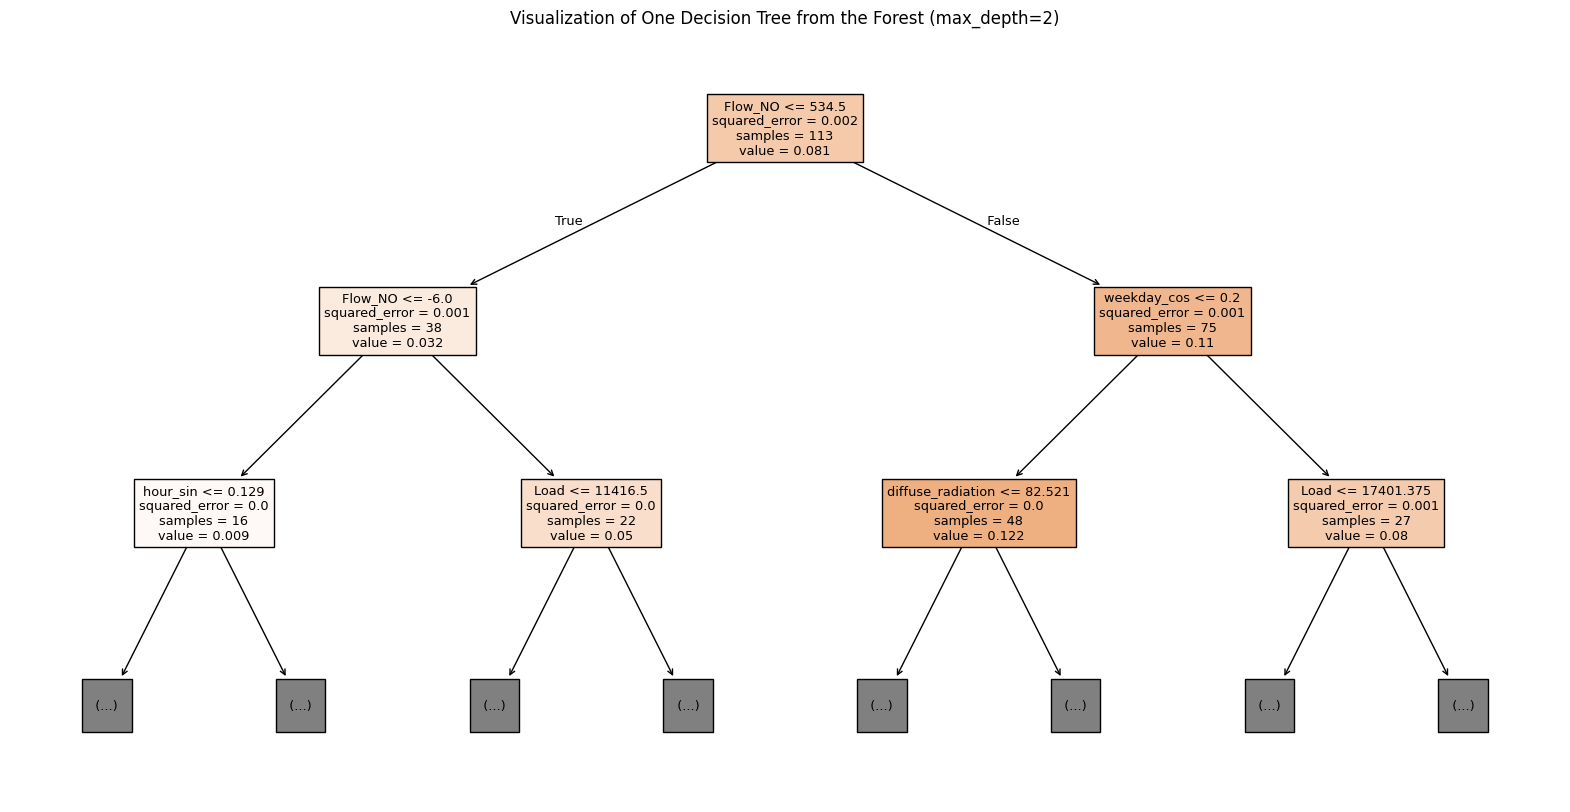

In [55]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=feature_names, filled=True, max_depth=2)
plt.title("Visualization of One Decision Tree from the Forest (max_depth=2)")
plt.show()

In [56]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pad naar de SQLite-database
db_path = 'C:/Users/shba/Documents/JADS project/ENEXIS/src/data/WARP2.db'

# Maak verbinding met de database
conn = sqlite3.connect(db_path)

# Lees de 'master_warp'-tabel in een Pandas DataFrame
query = "SELECT * FROM master_warp"
df = pd.read_sql_query(query, conn)

# Sluit de verbinding
conn.close()

# Controleer kolommen
print(df.columns)

# Stel een jaartal in (bijvoorbeeld 2025)
year = 2025

# Maak een nieuwe Timestamp kolom aan
df['Timestamp'] = pd.to_datetime({
    'year': year,
    'month': df['month'],
    'day': 1  # tijdelijke placeholder, wordt hieronder aangepast
}) + pd.to_timedelta(df['day_of_year'] - 1, unit='D') + pd.to_timedelta(df['hour'], unit='h')

# Feature engineering
df = df.dropna()

# Stel de periodes in
train_start = pd.Timestamp('2025-03-01')
train_end = pd.Timestamp('2025-03-07 23:59:59')
test_start = pd.Timestamp('2025-03-08')
test_end = pd.Timestamp('2025-03-14 23:59:59')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

# Features voor het model
features = [
    'hour', 'day_of_week',
    'yearday_sin', 'yearday_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 
    'hour_cos', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 
    'diffuse_radiation', 'Flow_NO', 'Flow_GB', 'month', 'is_dst', 'wind_speed_10m',
    'is_non_working_day', 'is_weekend', 'cloud_cover'
]

X_train = train[features]
y_train = train['Price']
X_test = test[features]
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

Index(['hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'yearday_sin', 'yearday_cos',
       'local_datetime', 'is_dst', 'is_holiday', 'is_weekend',
       'is_non_working_day', 'target_datetime', 'Load', 'Price', 'Flow_BE',
       'Flow_DE', 'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow',
       'temperature_2m', 'wind_speed_10m', 'apparent_temperature',
       'cloud_cover', 'snowfall', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'Wind_Vol',
       'WindOffshore_Vol', 'Solar_Vol', 'Nuclear_Vol'],
      dtype='object')
MAE: 0.017200075000000006
RMSE: 0.02162308524804376


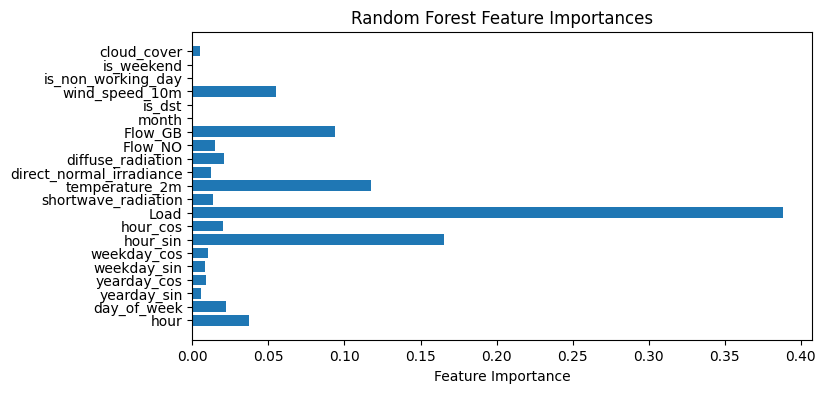

In [57]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

Index(['hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'yearday_sin', 'yearday_cos',
       'local_datetime', 'is_dst', 'is_holiday', 'is_weekend',
       'is_non_working_day', 'target_datetime', 'Load', 'Price', 'Flow_BE',
       'Flow_DE', 'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow',
       'temperature_2m', 'wind_speed_10m', 'apparent_temperature',
       'cloud_cover', 'snowfall', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'Wind_Vol',
       'WindOffshore_Vol', 'Solar_Vol', 'Nuclear_Vol'],
      dtype='object')
Train: 2025-01-01 to 2025-01-07, Test: 2025-01-08 to 2025-01-14, RMSE: 0.03
Train: 2025-01-02 to 2025-01-08, Test: 2025-01-09 to 2025-01-15, RMSE: 0.05
Train: 2025-01-03 to 2025-01-09, Test: 2025-01-10 to 2025-01-16, RMSE: 0.05
Train: 2025-01-04 to 2025-01-10, Test: 2025-01-11 to 2025-01-17, RMSE: 0.05
Train: 2025-01-05 to 2025-01-11, Test: 2025-01-12 to 2025-01-18, RMSE: 0.05
T

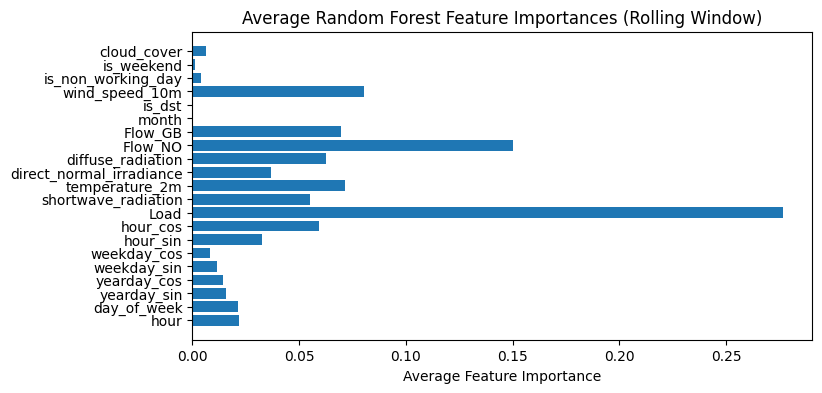

In [58]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pad naar de SQLite-database
db_path = 'C:/Users/shba/Documents/JADS project/ENEXIS/src/data/WARP2.db'

# Maak verbinding met de database
conn = sqlite3.connect(db_path)

# Lees de 'master_warp'-tabel in een Pandas DataFrame
query = "SELECT * FROM master_warp"
df = pd.read_sql_query(query, conn)

# Sluit de verbinding
conn.close()

# Controleer kolommen
print(df.columns)
all_preds = []
all_actuals = []
all_timestamps = []
all_horizons = []

# Stel een jaartal in (bijvoorbeeld 2025)
year = 2025

# Maak een nieuwe Timestamp kolom aan
df['Timestamp'] = pd.to_datetime(year * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['hour'], unit='h')

# Feature engineering
df = df.dropna()

# Parameters
window_size = 7  # days in training set
test_size = 7    # days in test set
step_size = 1    # days to roll forward
features = [
    'hour', 'day_of_week',
    'yearday_sin', 'yearday_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 
    'hour_cos', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 
    'diffuse_radiation', 'Flow_NO', 'Flow_GB', 'month', 'is_dst', 'wind_speed_10m',
    'is_non_working_day', 'is_weekend', 'cloud_cover'
]

# Prepare
df = df.sort_values('Timestamp').reset_index(drop=True)
start_date = pd.Timestamp('2025-01-01')
end_date = pd.Timestamp.today().normalize() - pd.Timedelta(days=window_size + test_size - 1)

rmses = []
maes = []
importances = []

current_start = start_date

while current_start <= end_date:
    train_start = current_start
    train_end = train_start + pd.Timedelta(days=window_size - 1, hours=23)
    test_start = train_end + pd.Timedelta(hours=1)
    test_end = test_start + pd.Timedelta(days=test_size - 1, hours=23)
    
    train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
    test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]
    
    if len(train) == 0 or len(test) == 0:
        current_start += pd.Timedelta(days=step_size)
        continue
    
    X_train = train[features]
    y_train = train['Price']
    X_test = test[features]
    y_test = test['Price']
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate horizon (days ahead) for each prediction in this test set
    horizons = ((test['Timestamp'] - test_start).dt.days).values
    
    all_preds.extend(y_pred)
    all_actuals.extend(y_test.values)
    all_timestamps.extend(test['Timestamp'].values)
    all_horizons.extend(horizons)

#Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    rmses.append(rmse)
    maes.append(mae)
    importances.append(model.feature_importances_)
    
    print(f"Train: {train_start.date()} to {train_end.date()}, Test: {test_start.date()} to {test_end.date()}, RMSE: {rmse:.2f}")
    
    current_start += pd.Timedelta(days=step_size)

# Now, build a DataFrame with the horizon included
result_df = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual': all_actuals,
    'Predicted': all_preds,
    'Horizon': all_horizons
})

# Pivot so each horizon is a column
pivot_df = result_df.pivot_table(index='Timestamp', columns='Horizon', values='Predicted', aggfunc='first')
pivot_df.columns = [f'Predicted_{int(h+1)}d_ahead' for h in pivot_df.columns]  # 1-based
pivot_df = pivot_df.reset_index()

print(pivot_df.head())

# Add actuals
actuals = result_df.drop_duplicates('Timestamp')[['Timestamp', 'Actual']]
pivot_df = pd.merge(pivot_df, actuals, on='Timestamp', how='left')

print(pivot_df.head())

# Gemiddelde RMSE, MAE en feature importance
print(f"\nAverage RMSE: {np.mean(rmses):.2f}")
print(f"Average MAE: {np.mean(maes):.2f}")

avg_importance = np.mean(importances, axis=0)
for name, imp in zip(features, avg_importance):
    print(f"{name}: {imp:.3f}")

# Visualiseer gemiddelde feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.barh(features, avg_importance)
plt.xlabel("Average Feature Importance")
plt.title("Average Random Forest Feature Importances (Rolling Window)")
plt.show()

In [59]:
# Gemiddelde RMSE, MAE en feature importance
print(f"\nAverage RMSE: {np.mean(rmses):.4f}")
print(f"Average MAE: {np.mean(maes):.4f}")


Average RMSE: 0.0370
Average MAE: 0.0256


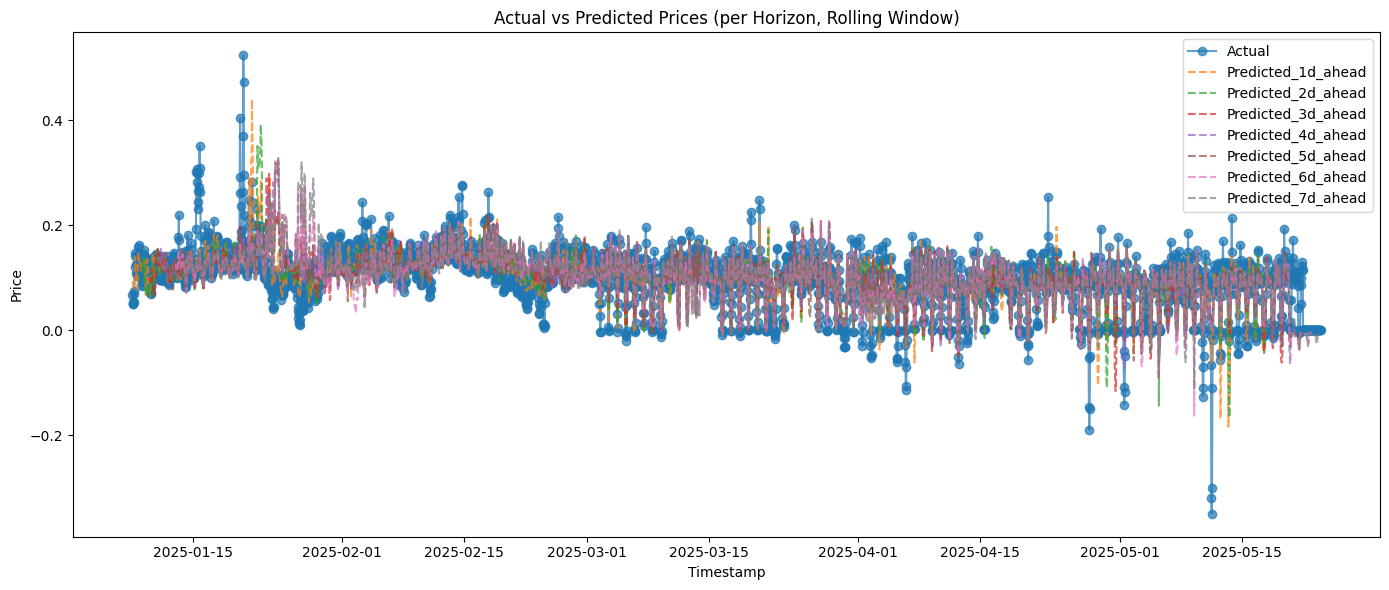

In [60]:
# Plot example: Actual vs 1-day, 2-day, ... ahead predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pivot_df['Timestamp'], pivot_df['Actual'], label='Actual', marker='o', linestyle='-', alpha=0.7)
for col in pivot_df.columns:
    if col.startswith('Predicted_'):
        plt.plot(pivot_df['Timestamp'], pivot_df[col], label=col, linestyle='--', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Prices (per Horizon, Rolling Window)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

In [61]:
df.to_csv("enexis_master_warp.csv", index=False)


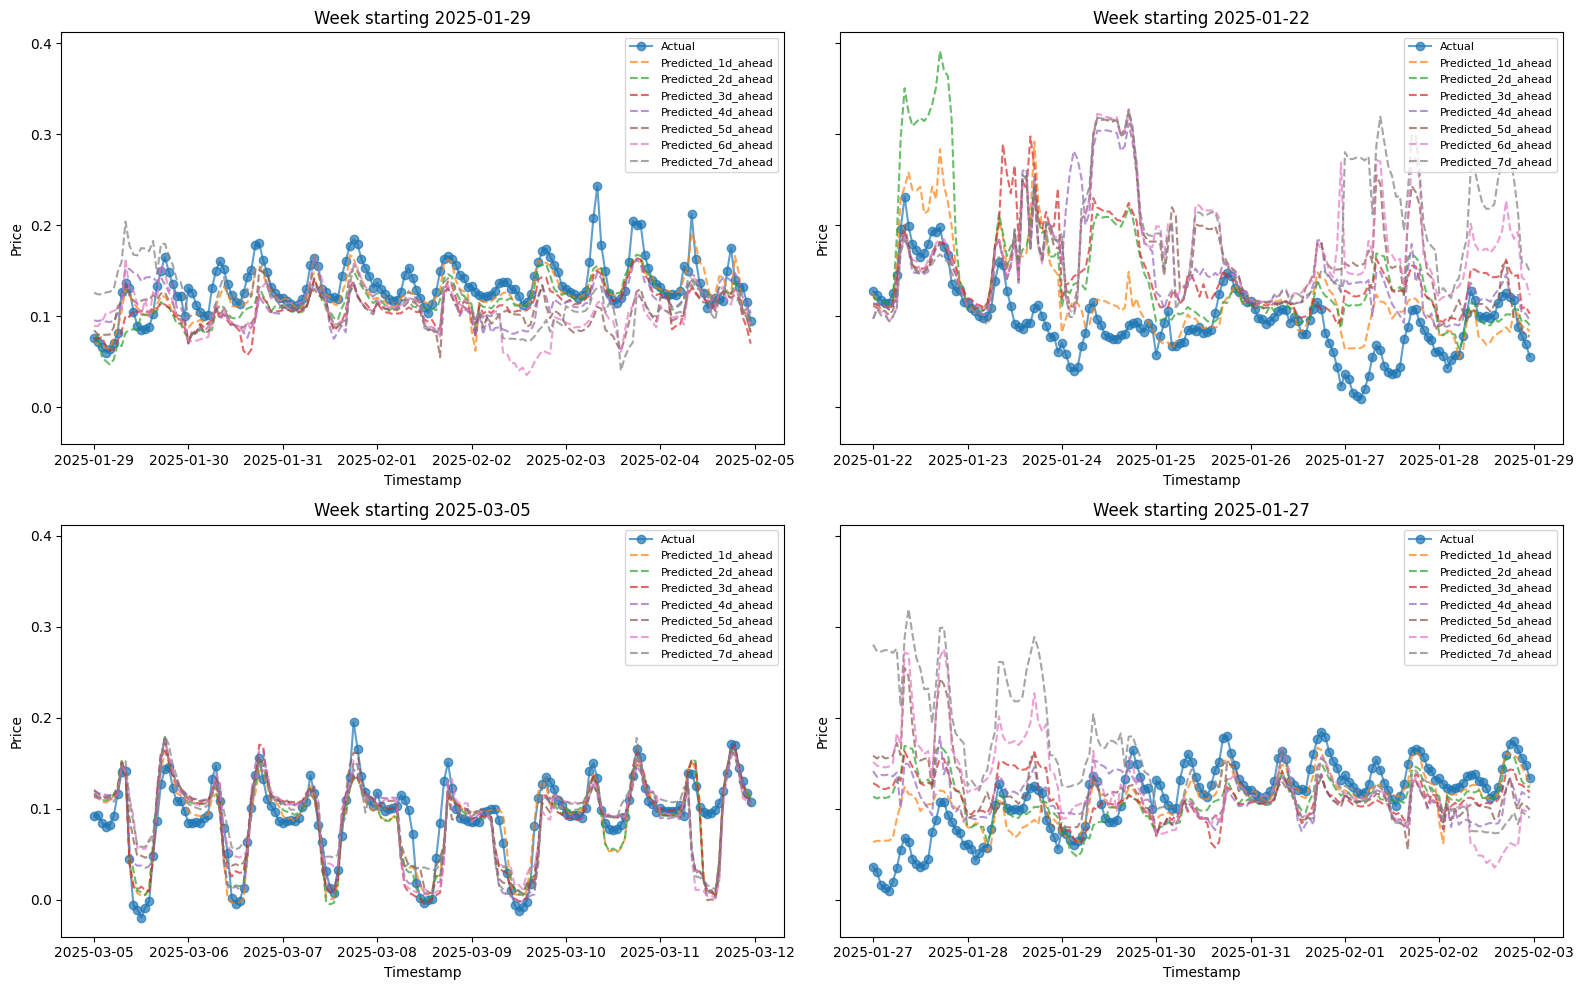

In [62]:
import matplotlib.pyplot as plt
import numpy as np

pivot_df['Timestamp'] = pd.to_datetime(pivot_df['Timestamp'])

unique_days = pivot_df['Timestamp'].dt.normalize().unique()
if len(unique_days) < 4:
    print("Niet genoeg weken in de data om 4 snapshots te maken.")
else:
    # np.random.seed(42)  # Remove this line for different random weeks each run
    chosen_starts = np.random.choice(unique_days[:-6], 4, replace=False)

    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
    axs = axs.flatten()

    for i, start_day in enumerate(chosen_starts):
        mask = (pivot_df['Timestamp'] >= start_day) & (pivot_df['Timestamp'] < start_day + np.timedelta64(7, 'D'))
        week_df = pivot_df[mask]

        ax = axs[i]
        ax.plot(week_df['Timestamp'], week_df['Actual'], label='Actual', marker='o', linestyle='-', alpha=0.7)
        for col in week_df.columns:
            if col.startswith('Predicted_'):
                ax.plot(week_df['Timestamp'], week_df[col], label=col, linestyle='--', alpha=0.7)
        ax.set_title(f"Week starting {pd.to_datetime(start_day).date()}")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Price")
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

In [63]:
import numpy as np

# Calculate RMSE per horizon
rmse_per_horizon = result_df.groupby('Horizon').apply(
    lambda g: np.sqrt(np.mean((g['Actual'] - g['Predicted'])**2))
)

# Print nicely
for h, rmse in rmse_per_horizon.items():
    print(f"Average RMSE for {int(h)+1} days ahead: {rmse:.4f}")

Average RMSE for 1 days ahead: 0.0322
Average RMSE for 2 days ahead: 0.0372
Average RMSE for 3 days ahead: 0.0376
Average RMSE for 4 days ahead: 0.0409
Average RMSE for 5 days ahead: 0.0436
Average RMSE for 6 days ahead: 0.0457
Average RMSE for 7 days ahead: 0.0479


C:\Users\shba\AppData\Local\Temp\ipykernel_12776\1407637168.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_horizon = result_df.groupby('Horizon').apply(


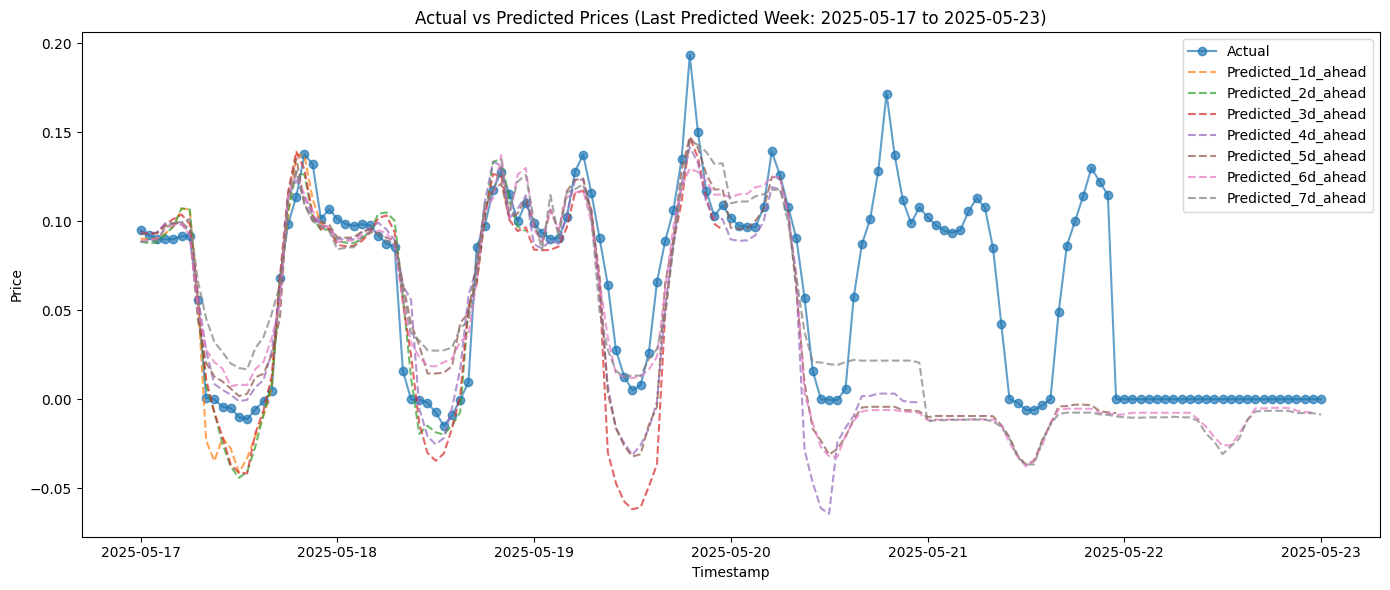

In [64]:
import matplotlib.pyplot as plt
import numpy as np

pivot_df['Timestamp'] = pd.to_datetime(pivot_df['Timestamp'])

# Bepaal de laatste dag in de data
last_day = pivot_df['Timestamp'].dt.normalize().max()
# Selecteer de laatste week
mask = (pivot_df['Timestamp'] >= last_day - np.timedelta64(6, 'D')) & (pivot_df['Timestamp'] <= last_day)
week_df = pivot_df[mask].copy()

# Zet ook alle voorspellingen op NaN waar Actual NaN is
for col in week_df.columns:
    if col.startswith('Predicted_'):
        week_df.loc[week_df['Actual'].isna(), col] = np.nan

# Verwijder rijen waar Actual NaN is (voor de x-as)
week_df = week_df.dropna(subset=['Actual'])

plt.figure(figsize=(14, 6))
plt.plot(week_df['Timestamp'], week_df['Actual'], label='Actual', marker='o', linestyle='-', alpha=0.7)
for col in week_df.columns:
    if col.startswith('Predicted_'):
        plt.plot(week_df['Timestamp'], week_df[col], label=col, linestyle='--', alpha=0.7)
plt.legend()
plt.title(f"Actual vs Predicted Prices (Last Predicted Week: {last_day.date() - pd.Timedelta(days=6)} to {last_day.date()})")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

Index(['hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'yearday_sin', 'yearday_cos',
       'local_datetime', 'is_dst', 'is_holiday', 'is_weekend',
       'is_non_working_day', 'target_datetime', 'Load', 'Price', 'Flow_BE',
       'Flow_DE', 'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow',
       'temperature_2m', 'wind_speed_10m', 'apparent_temperature',
       'cloud_cover', 'snowfall', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'Wind_Vol',
       'WindOffshore_Vol', 'Solar_Vol', 'Nuclear_Vol'],
      dtype='object')
Train: 2025-01-01 to 2025-01-07, Test: 2025-01-08 to 2025-01-14, RMSE: 0.04
Train: 2025-01-02 to 2025-01-08, Test: 2025-01-09 to 2025-01-15, RMSE: 0.06
Train: 2025-01-03 to 2025-01-09, Test: 2025-01-10 to 2025-01-16, RMSE: 0.06
Train: 2025-01-04 to 2025-01-10, Test: 2025-01-11 to 2025-01-17, RMSE: 0.06
Train: 2025-01-05 to 2025-01-11, Test: 2025-01-12 to 2025-01-18, RMSE: 0.05
T

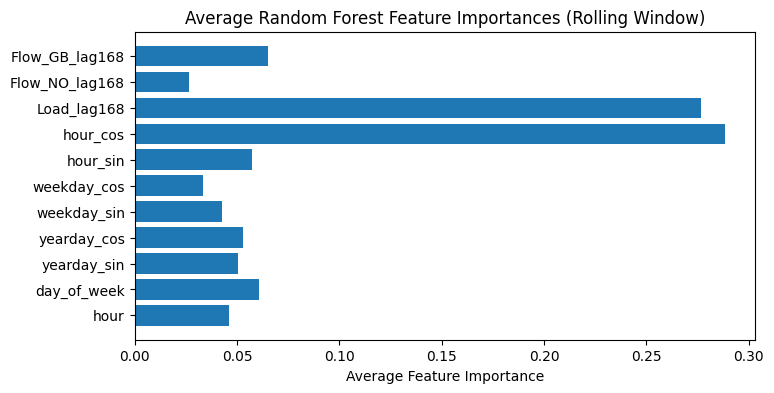

In [85]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pad naar de SQLite-database
db_path = 'C:/Users/shba/Documents/JADS project/ENEXIS/src/data/WARP2.db'

# Maak verbinding met de database
conn = sqlite3.connect(db_path)

# Lees de 'master_warp'-tabel in een Pandas DataFrame
query = "SELECT * FROM master_warp"
df = pd.read_sql_query(query, conn)

# Sluit de verbinding
conn.close()

# Controleer kolommen
print(df.columns)
all_preds = []
all_actuals = []
all_timestamps = []
all_horizons = []

# Stel een jaartal in (bijvoorbeeld 2025)
year = 2025

# Maak een nieuwe Timestamp kolom aan
df['Timestamp'] = pd.to_datetime(year * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['hour'], unit='h')

# Feature engineering
df = df.dropna()

# Voeg een 7-daagse lag toe (168 uur terug)
df['Load_lag168'] = df['Load'].shift(168)
df['Flow_NO_lag168'] = df['Flow_NO'].shift(168)
df['Flow_GB_lag168'] = df['Flow_GB'].shift(168)


# Parameters
window_size = 7  # days in training set
test_size = 7    # days in test set
step_size = 1    # days to roll forward
features = [
    'hour', 'day_of_week',
    'yearday_sin', 'yearday_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 
    'hour_cos', 'Load_lag168', 'Flow_NO_lag168', 'Flow_GB_lag168']

# Prepare
df = df.sort_values('Timestamp').reset_index(drop=True)
start_date = pd.Timestamp('2025-01-01')
end_date = pd.Timestamp.today().normalize() - pd.Timedelta(days=window_size + test_size - 1)

rmses = []
maes = []
importances = []

current_start = start_date

while current_start <= end_date:
    train_start = current_start
    train_end = train_start + pd.Timedelta(days=window_size - 1, hours=23)
    test_start = train_end + pd.Timedelta(hours=1)
    test_end = test_start + pd.Timedelta(days=test_size - 1, hours=23)
    
    train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
    test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]
    
    if len(train) == 0 or len(test) == 0:
        current_start += pd.Timedelta(days=step_size)
        continue
    
    X_train = train[features]
    y_train = train['Price']
    X_test = test[features]
    y_test = test['Price']
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate horizon (days ahead) for each prediction in this test set
    horizons = ((test['Timestamp'] - test_start).dt.days).values
    
    all_preds.extend(y_pred)
    all_actuals.extend(y_test.values)
    all_timestamps.extend(test['Timestamp'].values)
    all_horizons.extend(horizons)

#Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    rmses.append(rmse)
    maes.append(mae)
    importances.append(model.feature_importances_)
    
    print(f"Train: {train_start.date()} to {train_end.date()}, Test: {test_start.date()} to {test_end.date()}, RMSE: {rmse:.2f}")
    
    current_start += pd.Timedelta(days=step_size)

# Now, build a DataFrame with the horizon included
result_df = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual': all_actuals,
    'Predicted': all_preds,
    'Horizon': all_horizons
})

# Pivot so each horizon is a column
pivot_df = result_df.pivot_table(index='Timestamp', columns='Horizon', values='Predicted', aggfunc='first')
pivot_df.columns = [f'Predicted_{int(h+1)}d_ahead' for h in pivot_df.columns]  # 1-based
pivot_df = pivot_df.reset_index()

print(pivot_df.head())

# Add actuals
actuals = result_df.drop_duplicates('Timestamp')[['Timestamp', 'Actual']]
pivot_df = pd.merge(pivot_df, actuals, on='Timestamp', how='left')

print(pivot_df.head())

# Gemiddelde RMSE, MAE en feature importance
print(f"\nAverage RMSE: {np.mean(rmses):.2f}")
print(f"Average MAE: {np.mean(maes):.2f}")

avg_importance = np.mean(importances, axis=0)
for name, imp in zip(features, avg_importance):
    print(f"{name}: {imp:.3f}")

# Visualiseer gemiddelde feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.barh(features, avg_importance)
plt.xlabel("Average Feature Importance")
plt.title("Average Random Forest Feature Importances (Rolling Window)")
plt.show()

In [86]:
# Gemiddelde RMSE, MAE en feature importance
print(f"\nAverage RMSE: {np.mean(rmses):.4f}")
print(f"Average MAE: {np.mean(maes):.4f}")


Average RMSE: 0.0458
Average MAE: 0.0329


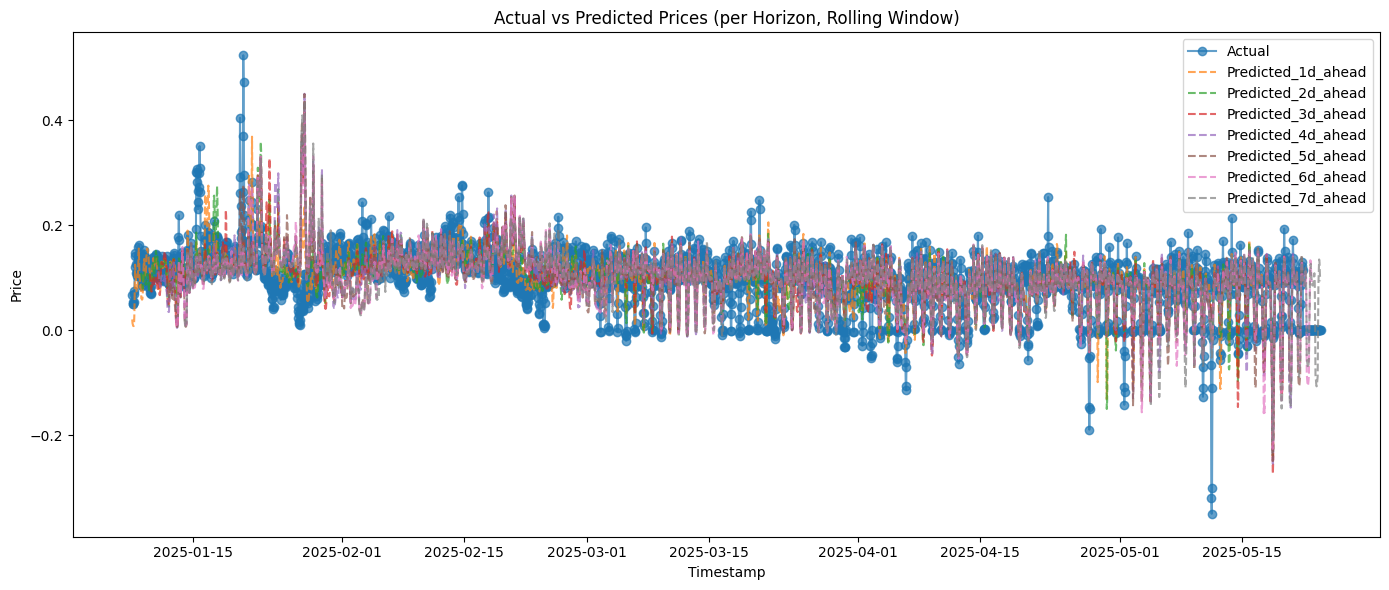

In [87]:
# Plot example: Actual vs 1-day, 2-day, ... ahead predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pivot_df['Timestamp'], pivot_df['Actual'], label='Actual', marker='o', linestyle='-', alpha=0.7)
for col in pivot_df.columns:
    if col.startswith('Predicted_'):
        plt.plot(pivot_df['Timestamp'], pivot_df[col], label=col, linestyle='--', alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Prices (per Horizon, Rolling Window)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

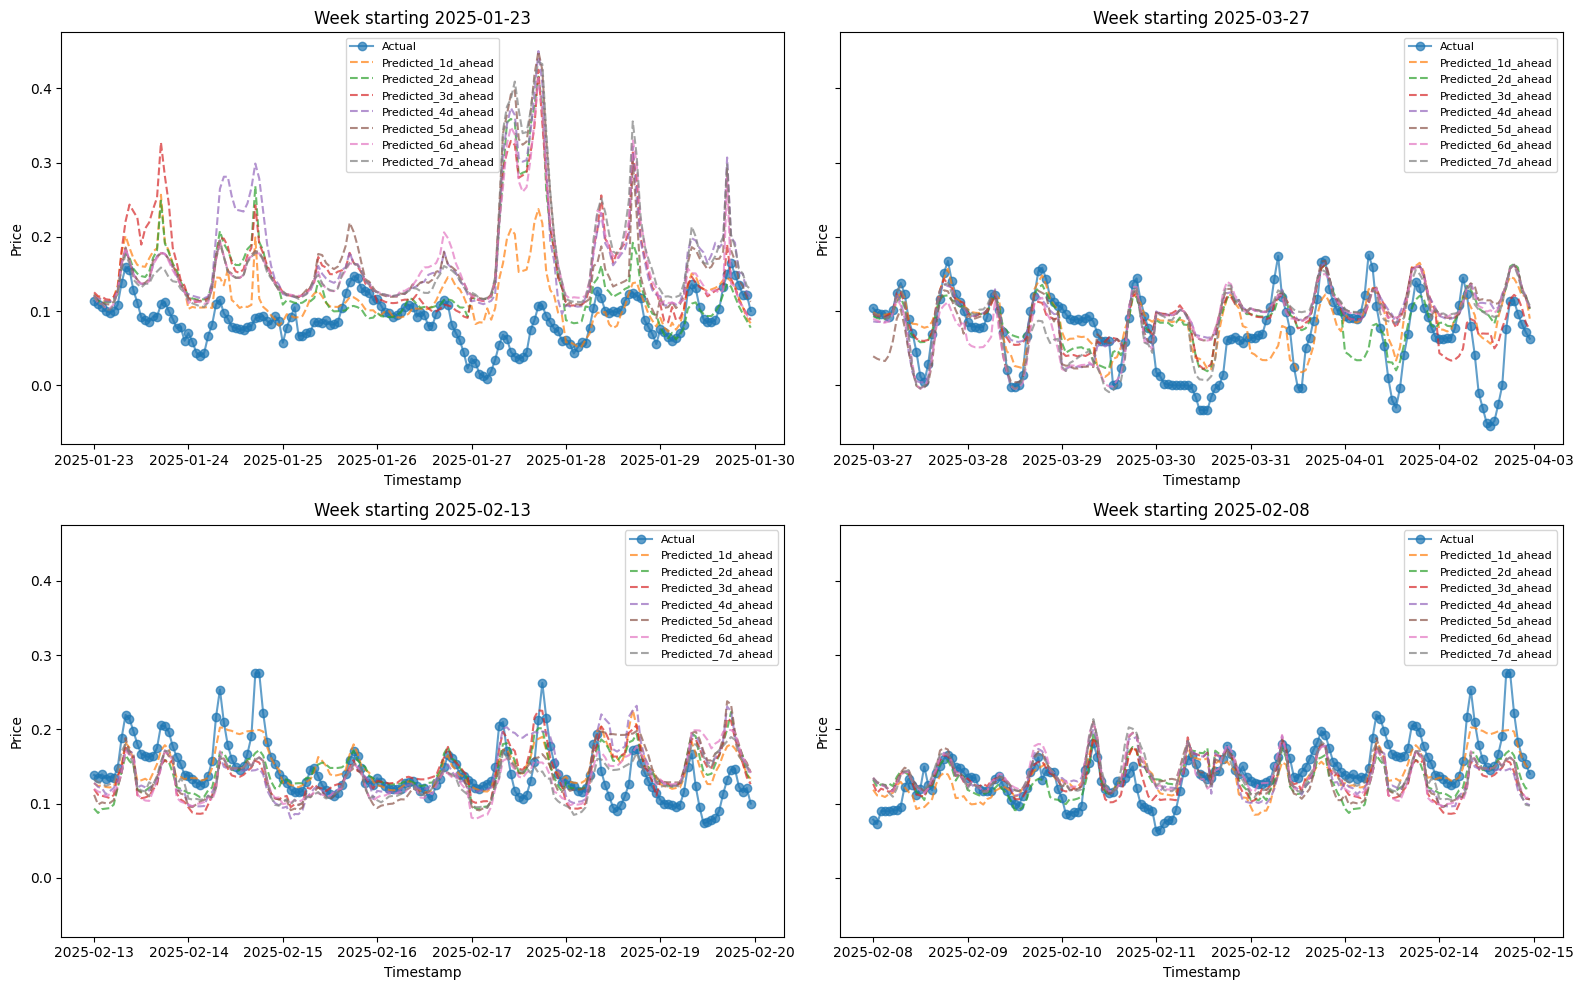

In [88]:
import matplotlib.pyplot as plt
import numpy as np

pivot_df['Timestamp'] = pd.to_datetime(pivot_df['Timestamp'])

unique_days = pivot_df['Timestamp'].dt.normalize().unique()
if len(unique_days) < 4:
    print("Niet genoeg weken in de data om 4 snapshots te maken.")
else:
    # np.random.seed(42)  # Remove this line for different random weeks each run
    chosen_starts = np.random.choice(unique_days[:-6], 4, replace=False)

    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
    axs = axs.flatten()

    for i, start_day in enumerate(chosen_starts):
        mask = (pivot_df['Timestamp'] >= start_day) & (pivot_df['Timestamp'] < start_day + np.timedelta64(7, 'D'))
        week_df = pivot_df[mask]

        ax = axs[i]
        ax.plot(week_df['Timestamp'], week_df['Actual'], label='Actual', marker='o', linestyle='-', alpha=0.7)
        for col in week_df.columns:
            if col.startswith('Predicted_'):
                ax.plot(week_df['Timestamp'], week_df[col], label=col, linestyle='--', alpha=0.7)
        ax.set_title(f"Week starting {pd.to_datetime(start_day).date()}")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Price")
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

In [89]:
import numpy as np

# Calculate RMSE per horizon
rmse_per_horizon = result_df.groupby('Horizon').apply(
    lambda g: np.sqrt(np.mean((g['Actual'] - g['Predicted'])**2))
)

# Print nicely
for h, rmse in rmse_per_horizon.items():
    print(f"Average RMSE for {int(h)+1} days ahead: {rmse:.4f}")

Average RMSE for 1 days ahead: 0.0368
Average RMSE for 2 days ahead: 0.0446
Average RMSE for 3 days ahead: 0.0484
Average RMSE for 4 days ahead: 0.0527
Average RMSE for 5 days ahead: 0.0525
Average RMSE for 6 days ahead: 0.0530
Average RMSE for 7 days ahead: 0.0535


C:\Users\shba\AppData\Local\Temp\ipykernel_12776\1407637168.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_horizon = result_df.groupby('Horizon').apply(


In [90]:
import sqlite3

db_path = 'C:/Users/shba/Documents/JADS project/ENEXIS/src/data/WARP2.db'
conn = sqlite3.connect(db_path)

# Haal alle tabelnamen op
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
conn.close()

# Print de tabelnamen
for t in tables:
    print(t[0])

raw_ned_obs
transform_ned_obs
raw_ned_df
raw_meteo_preds_history
raw_meteo_obs
transform_meteo_forecast_now
transform_weather_preds_history
raw_ned_obs_2
transform_weather_obs
transform_ned_obs_2
raw_NED_preds
raw_meteo_forecast_now
processed_NED_preds
dim_datetime
raw_weather_obs
raw_weather_preds_test
raw_meteo_obs_test
raw_entsoe_obs
transform_entsoe_obs
raw_weather_preds
process_weather_preds
master_warp
master_predictions
training_set


In [74]:
import sqlite3
import pandas as pd

# Pad naar de SQLite-database
db_path = 'C:/Users/shba/Documents/JADS project/ENEXIS/src/data/WARP2.db'

# Maak verbinding met de database
conn = sqlite3.connect(db_path)

# Lees de 'raw_entsoe_obs'-tabel in een Pandas DataFrame
query = "SELECT * FROM master_predictions"
df_pred = pd.read_sql_query(query, conn)

# Sluit de verbinding
conn.close()

print(df_pred.head())

df_pred.to_csv("enexis_mastepr_predictions.csv", index=False)



   hour  day_of_week  month  day_of_year  hour_sin  hour_cos  weekday_sin  \
0     0            2      1            1  0.000000  1.000000     0.974928   
1     1            2      1            1  0.258819  0.965926     0.974928   
2     2            2      1            1  0.500000  0.866025     0.974928   
3     3            2      1            1  0.707107  0.707107     0.974928   
4     4            2      1            1  0.866025  0.500000     0.974928   

   weekday_cos  yearday_sin  yearday_cos  ... run_date  wind_speed_10m  \
0    -0.222521     0.017202     0.999852  ...     None             NaN   
1    -0.222521     0.017202     0.999852  ...     None             NaN   
2    -0.222521     0.017202     0.999852  ...     None             NaN   
3    -0.222521     0.017202     0.999852  ...     None             NaN   
4    -0.222521     0.017202     0.999852  ...     None             NaN   

   wind_direction_10m  cloud_cover  snowfall apparent_temperature  \
0                 NaN  

In [77]:
df_apr = df[df['Timestamp'] >= pd.Timestamp(f'{year}-04-02')]

# Stel een jaartal in (bijvoorbeeld 2025)
year = 2025

# Maak een nieuwe Timestamp kolom aan
df_pred['Timestamp'] = pd.to_datetime({
    'year': year,
    'month': df['month'],
    'day': 1  # tijdelijke placeholder, wordt hieronder aangepast
}) + pd.to_timedelta(df['day_of_year'] - 1, unit='D') + pd.to_timedelta(df['hour'], unit='h')


df_pred_apr = df_pred[df_pred['Timestamp'] >= pd.Timestamp(f'{year}-04-02')]